## Wikipeda web scraper 

Predict next winning
time using polynomal regression

In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import re
import numpy as np
from collections import Counter
import matplotlib.gridspec as gridspec
import numpy
from sklearn.metrics import r2_score

# YARDS!!!

# list of results per year
dfList = []

# list of olympic years
years = []

# OI 1904 measure was yard, instead of metre 
measure = []

# starting url. OI 2020
currentUrl= "https://en.wikipedia.org/wiki/Swimming_at_the_2020_Summer_Olympics_%E2%80%93_Men%27s_100_metre_freestyle"

nationMedalists = []
nationWinners = []

medalNationNames = []
medalNationMedals= []

winnerNationNames = []
winnerNationMedals= []

laneWinners=[]

laneMedals=[]

winnerTimes= []

In [2]:
# parse current page
def getSoup(urlWiki):
    response = requests.get(
        url=urlWiki,
    )
    soup = BeautifulSoup(response.content, 'html.parser')
    return soup
#metre  or yard
def getMeasure(soup):
    titleHeader = soup.find(id="firstHeading")
    title = titleHeader.string
    metre = "metre" in title
    return metre

#get year
def getYear(soup):
    titleHeader = soup.find(id="firstHeading")
    title = titleHeader.string
    yearMatch  = re.search(r'[12]\d{3}', title)
    yearStr = yearMatch.group(0)
    return yearStr

def getRace(soup):
    titleHeader = soup.find(id="firstHeading")
    title = titleHeader.string
    race = title.split("–",1)[1]
    return race
    
# get "Final" table
def getTable(soup):

    final = soup.find(id="Final")
    if final:
            header= final.parent
            resultsTable=header.findNext('table')

    else:
        final = soup.find(id="Final_A")
        if final:
            header= final.parent
            resultsTable=header.findNext('table')
        else:
            final = soup.find(id="Results")
            header= final.parent
            resultsTable=header.findNext('table')
    
    return resultsTable

#convert time to seconds
def convertToSeconds(x):
    x = x.split(":")
    if len(x) == 2:
        return float(x[0]) * 60 + float(x[1])
    return float(x[0]) * 3600 + float(x[1]) * 60 + float(x[2])

# medals have images instead of numbers
# there is not always exactly 1g 1s 1b medal
def getMedals(resultsTable, position):
    medals = 0
    place = "1st"
    medal="gold"
    
    if position == 2:
        place = "2nd"
        medal = "silver"
    elif position == 3:
        place = "3rd"
        medal = "bronze"
        
    medalTags = resultsTable.find_all("img", {"alt": place+" place, "+medal+" medalist(s)"})
    for tag in medalTags:
        medals+=1
    return medals


# convert final results to data frame
def createDataFrame(resultsTable, goldMedals, silverMedals, bronzeMedals):
    
    df=pd.read_html(str(resultsTable))
    # convert list to dataframe
    df=pd.DataFrame(df[0])
    
 # replace nulls with appropriate medals   
    for i in range(goldMedals):
        df["Rank"] = df["Rank"].fillna(1, limit=1)
        goldMedals-=1
        
    for i in range(silverMedals):
        df["Rank"] = df["Rank"].fillna(2, limit=1)
        silverMedals-=1
        
    for i in range(bronzeMedals):
        df["Rank"] = df["Rank"].fillna(3, limit=1)
        bronzeMedals-=1
    #change rank type to integer CLEANING
    #df = df.astype({'Rank':'int'})
    
    return df    

def getMedalNations(df,medals):
    nations = []
    for i in range(medals):
        nations.append(df["Nation"].iat[i])
    return nations

def getMedalLanes(df,medals):
    lanes = []
    for i in range(medals):
        lanes.append(df["Lane"].iat[i])
    return lanes

def cleanData(df):   
    #replacing DSQ with 0
    #df["Rank"] = df["Rank"].replace("—",0)    
    #df = df[df.Rank!= "3–10"]
    df.rename(columns = {'Time (2nd)':'Time'}, inplace = True)
    df.rename(columns = {'Name':'Swimmer'}, inplace = True)
    df = df[df.Time != "Unknown"]
    df = df[df.Time != "—"]
    df = df[df.Time != "DNS"]
    
    #df = pd.to_datetime(df['Time'], format="%H:%M:%S")
    df = df.astype({'Rank':'int'})
    df = df.astype({'Time':'str'})
    
    df['Time'] = '0:' + df['Time'].astype(str)
    df["Time"] = df["Time"].apply(convertToSeconds)
   
    return df


# go to the previous OI
def getPrevious(soup):
    previous=soup.find(class_="infobox-below noprint nowrap")
    children = previous.find_all("a")
    
    # for 1896 OI there are no previous OI, just the next one. When there are no new OI 
    if len(children)==2:
        urlNew="https://en.wikipedia.org"+ children[0]['href']
    else:
        urlNew=""
    return urlNew

def countDistinctNation(nations):
    nationsCount = (word for word in nations if word[:1].isupper())
    Count = Counter(nationsCount)
    distinctNations = Count.most_common(5)
    return distinctNations

In [3]:
#get the results

while currentUrl !="": 
    
    #print(currentUrl)
    soup = getSoup(currentUrl)

    year = getYear(soup)

    #years.reverse()
               
    metre = getMeasure(soup)
    if metre!=True: year = year+" *"
    measure.append(metre)
    years.append(year)
    resultsTable = getTable(soup)
    
    goldMedals = getMedals(resultsTable, 1)
    silverMedals = getMedals(resultsTable, 2)
    bronzeMedals = getMedals(resultsTable, 3)
    
    totalMedals = goldMedals + silverMedals + bronzeMedals
    
    df = createDataFrame(resultsTable, goldMedals, silverMedals, bronzeMedals)
 
    
    nations = getMedalNations(df,totalMedals)
    nationMedalists.extend(nations)
    nationWinners.append(df["Nation"].iat[0])
    
    if "Lane" in df:
        lanes = getMedalLanes(df,totalMedals)
        laneMedals.extend(lanes)
        laneWinners.append(df["Lane"].iat[0])
        
    df = cleanData(df) 
    
    winnerTime = df["Time"].iat[0]
    winnerTimes.append(winnerTime)

    dfList.append(df)
    currentUrl= getPrevious(soup)
    #print(df.head(10))
race = getRace(soup)
years.reverse()    
winnerTimes.reverse()

laneWinnerCount=Counter(laneWinners)
laneMedalsCount=Counter(laneMedals)

print(nationMedalists)    

print (years)
print (measure)
for df in dfList:
    print(df.head(10))
    result = df.dtypes
    print(result)
    
medalNations = countDistinctNation(nationMedalists)
print (medalNations)

for medal in medalNations:
    medalNationNames.append(medal[0])
    medalNationMedals.append(medal[1])

winnerNations = countDistinctNation(nationWinners)
print (winnerNations)

for winner in winnerNations:
    winnerNationNames.append(winner[0])
    winnerNationMedals.append(winner[1])
#for i in range(len(npList)-1):
#npList[0]= np.concatenate((npList[0],npList[1]), axis = 0)
#print(nationList)
print(nationWinners)


['United States', 'Australia', 'ROC', 'Australia', 'Belgium', 'United States', 'United States', 'Australia', 'Canada', 'France', 'Australia', 'United States', 'Brazil', 'Netherlands', 'South Africa', 'Australia', 'Netherlands', 'Russia', 'United States', 'Russia', 'United States', 'Brazil', 'Unified Team', 'Brazil', 'France', 'United States', 'United States', 'France', 'United States', 'Australia', 'Sweden', 'East Germany', 'Sweden', 'Sweden', 'United States', 'United States', 'West Germany', 'United States', 'United States', 'Soviet Union', 'Australia', 'United States', 'United States', 'United States', 'Great Britain', 'United Team of Germany', 'Australia', 'United States', 'Brazil', 'Australia', 'Australia', 'Australia', 'United States', 'Japan', 'Sweden', 'United States', 'United States', 'Hungary', 'Hungary', 'Japan', 'Japan', 'Japan', 'Japan', 'United States', 'United States', 'Hungary', 'Japan', 'United States', 'United States', 'United States', 'United States', 'United States',

C:\Users\milos\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


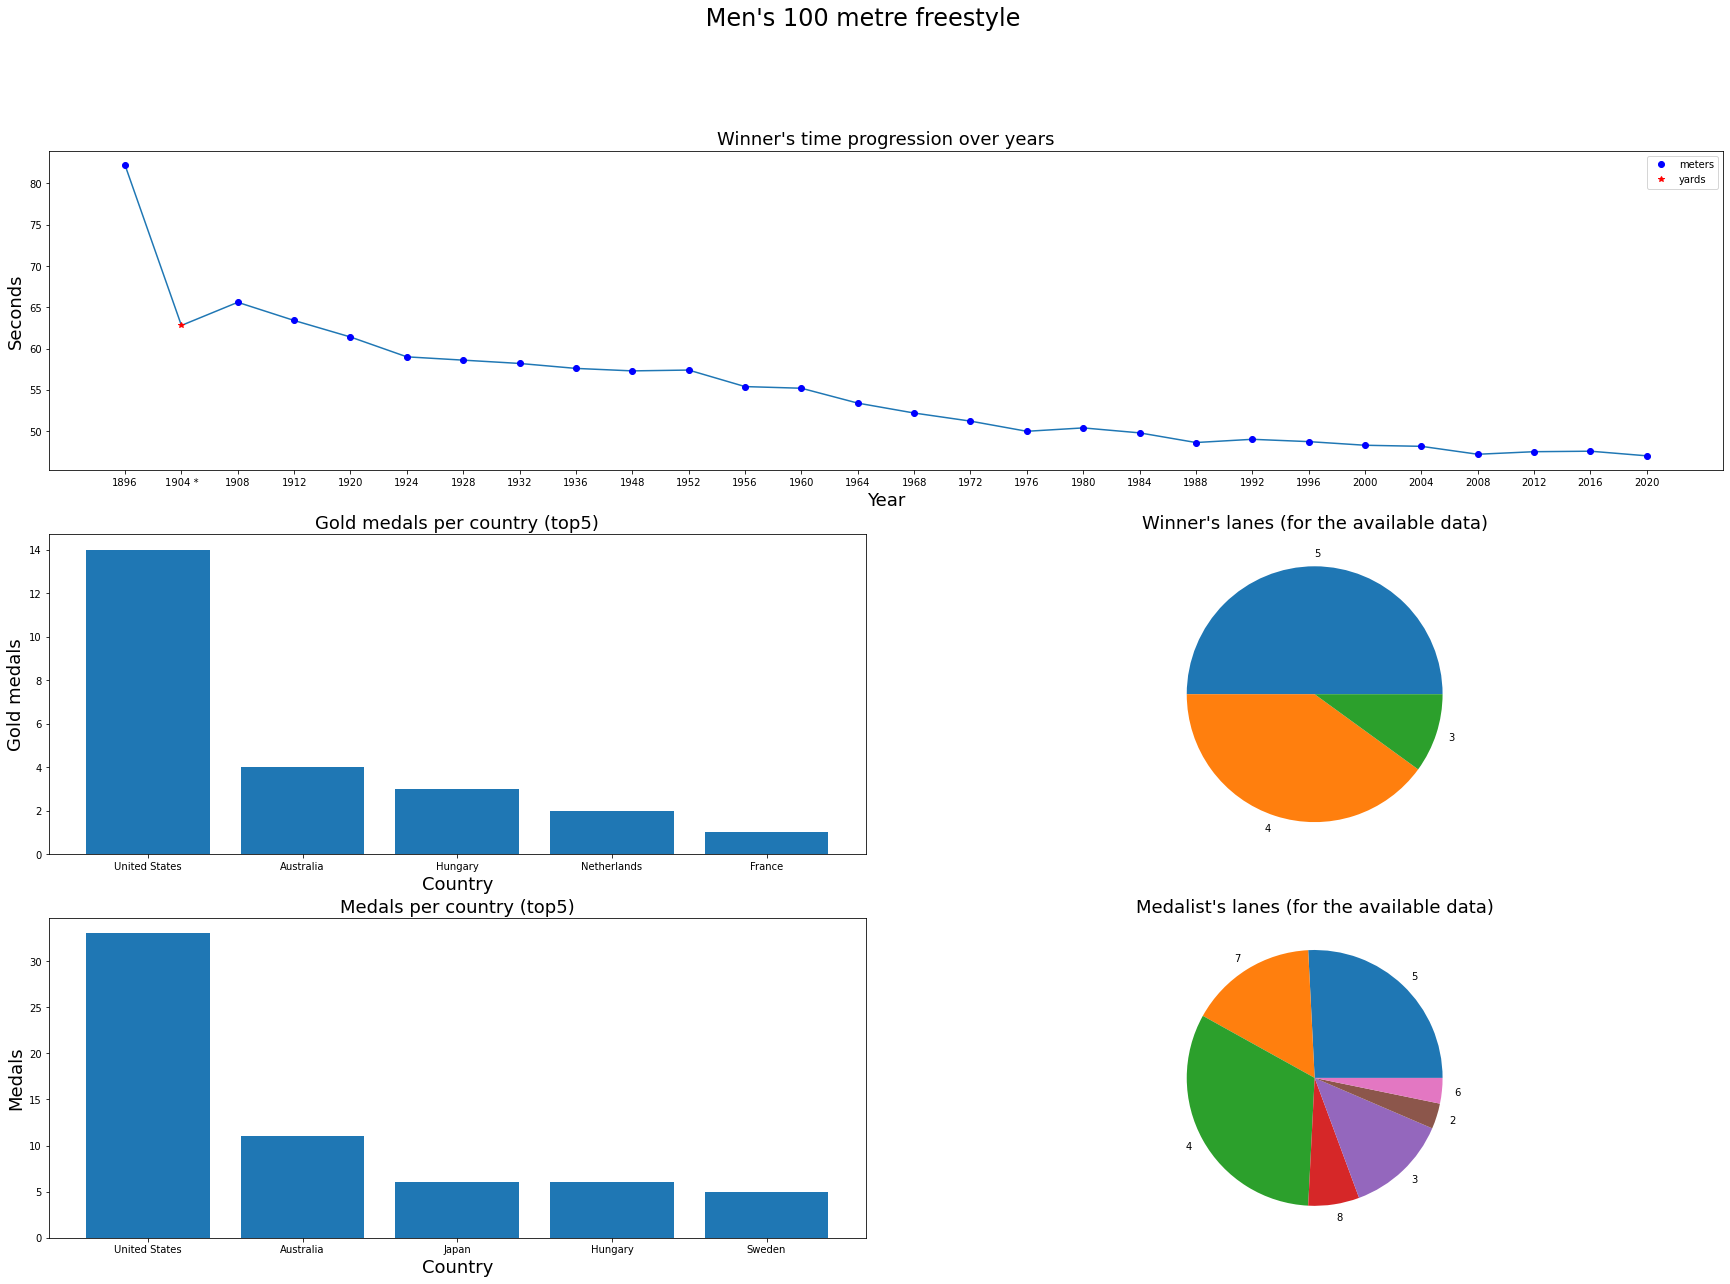

45.5526077747345 s
0.9951832749310275


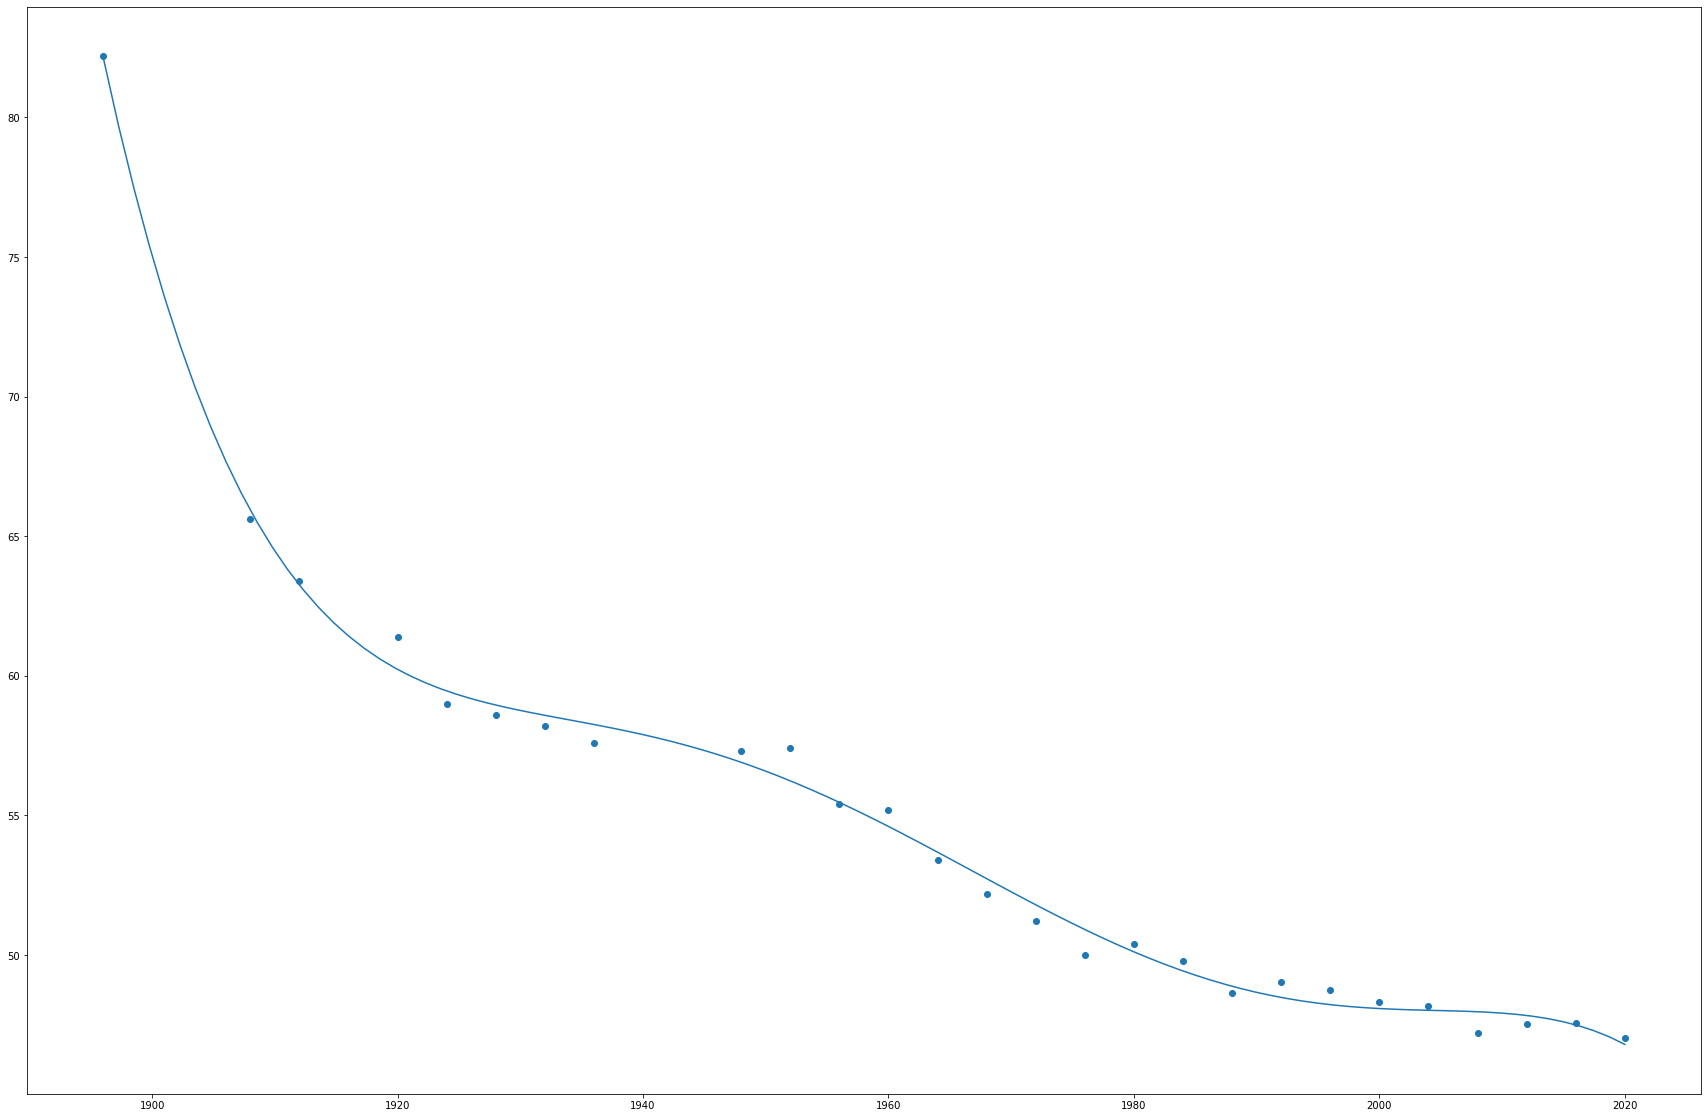

In [4]:

# plotting
plt.rcParams['figure.figsize'] = [30, 20]
fig = plt.figure(tight_layout=True)
gs = gridspec.GridSpec(3, 2, wspace=0.05)# remove if not necessary, wspace=0.1, hspace=0.1)

ax = fig.add_subplot(gs[0, :])
ax.plot(years,winnerTimes)
counter=0
for i in range(len(years)):
    
    if "*" in years[i]:
        ax.plot(years[i], winnerTimes[i], 'r*', label="yards")
    elif counter == 0:    
        ax.plot(years[i], winnerTimes[i], 'bo', label="meters")
        counter +=1
    else:
        ax.plot(years[i], winnerTimes[i], 'bo')
ax.legend(loc="upper right")
ax.set_ylabel('Seconds', fontsize=18)
ax.set_xlabel('Year', fontsize=18)
ax.set_title("Winner's time progression over years", fontsize=18)

ax = fig.add_subplot(gs[1, 0])
ax.bar(winnerNationNames, winnerNationMedals)
ax.set_ylabel('Gold medals', fontsize=18)
ax.set_xlabel('Country', fontsize=18)
ax.set_title("Gold medals per country (top5)", fontsize=18)

ax = fig.add_subplot(gs[1, 1])
ax.pie(laneWinnerCount.values(), labels=laneWinnerCount.keys())
ax.set_title("Winner's lanes (for the available data)", fontsize=18)

ax = fig.add_subplot(gs[2, 0])
ax.bar(medalNationNames, medalNationMedals)
ax.set_ylabel('Medals', fontsize=18)
ax.set_xlabel('Country', fontsize=18)
ax.set_title("Medals per country (top5)", fontsize=18)

ax = fig.add_subplot(gs[2, 1])
ax.pie(laneMedalsCount.values(), labels=laneMedalsCount.keys())

ax.set_title("Medalist's lanes (for the available data)", fontsize=18)


fig.align_labels()  # same as fig.align_xlabels(); fig.align_ylabels()

fig.suptitle(race, fontsize=24)

plt.show()

#polynomal regression
#copy of years and winner,maybe not neede
yearsNew= years.copy()
winnerTimesNew = winnerTimes.copy()

#exclude yards
for i in range(len(yearsNew)):
    if "*" in years[i]:
        del yearsNew[i]
        del winnerTimesNew[i]

#convert years from string to integer
yearsNew=list(map(int,yearsNew)) 

#scatter years and winner times
plt.scatter(yearsNew,winnerTimesNew)

#making model for 5th degree polynome, 
mymodel = numpy.poly1d(numpy.polyfit(yearsNew,winnerTimesNew, 5))
myline = numpy.linspace(1896, 2020, 100)

#next winner prediction
nextWinnerTime = mymodel(2024)
print(nextWinnerTime, "s")

#corelation
print(r2_score(winnerTimesNew, mymodel(yearsNew)))

#plot polynomal results
plt.plot(myline, mymodel(myline))
plt.show()
